In [2]:
import pandas as pd
import datetime
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

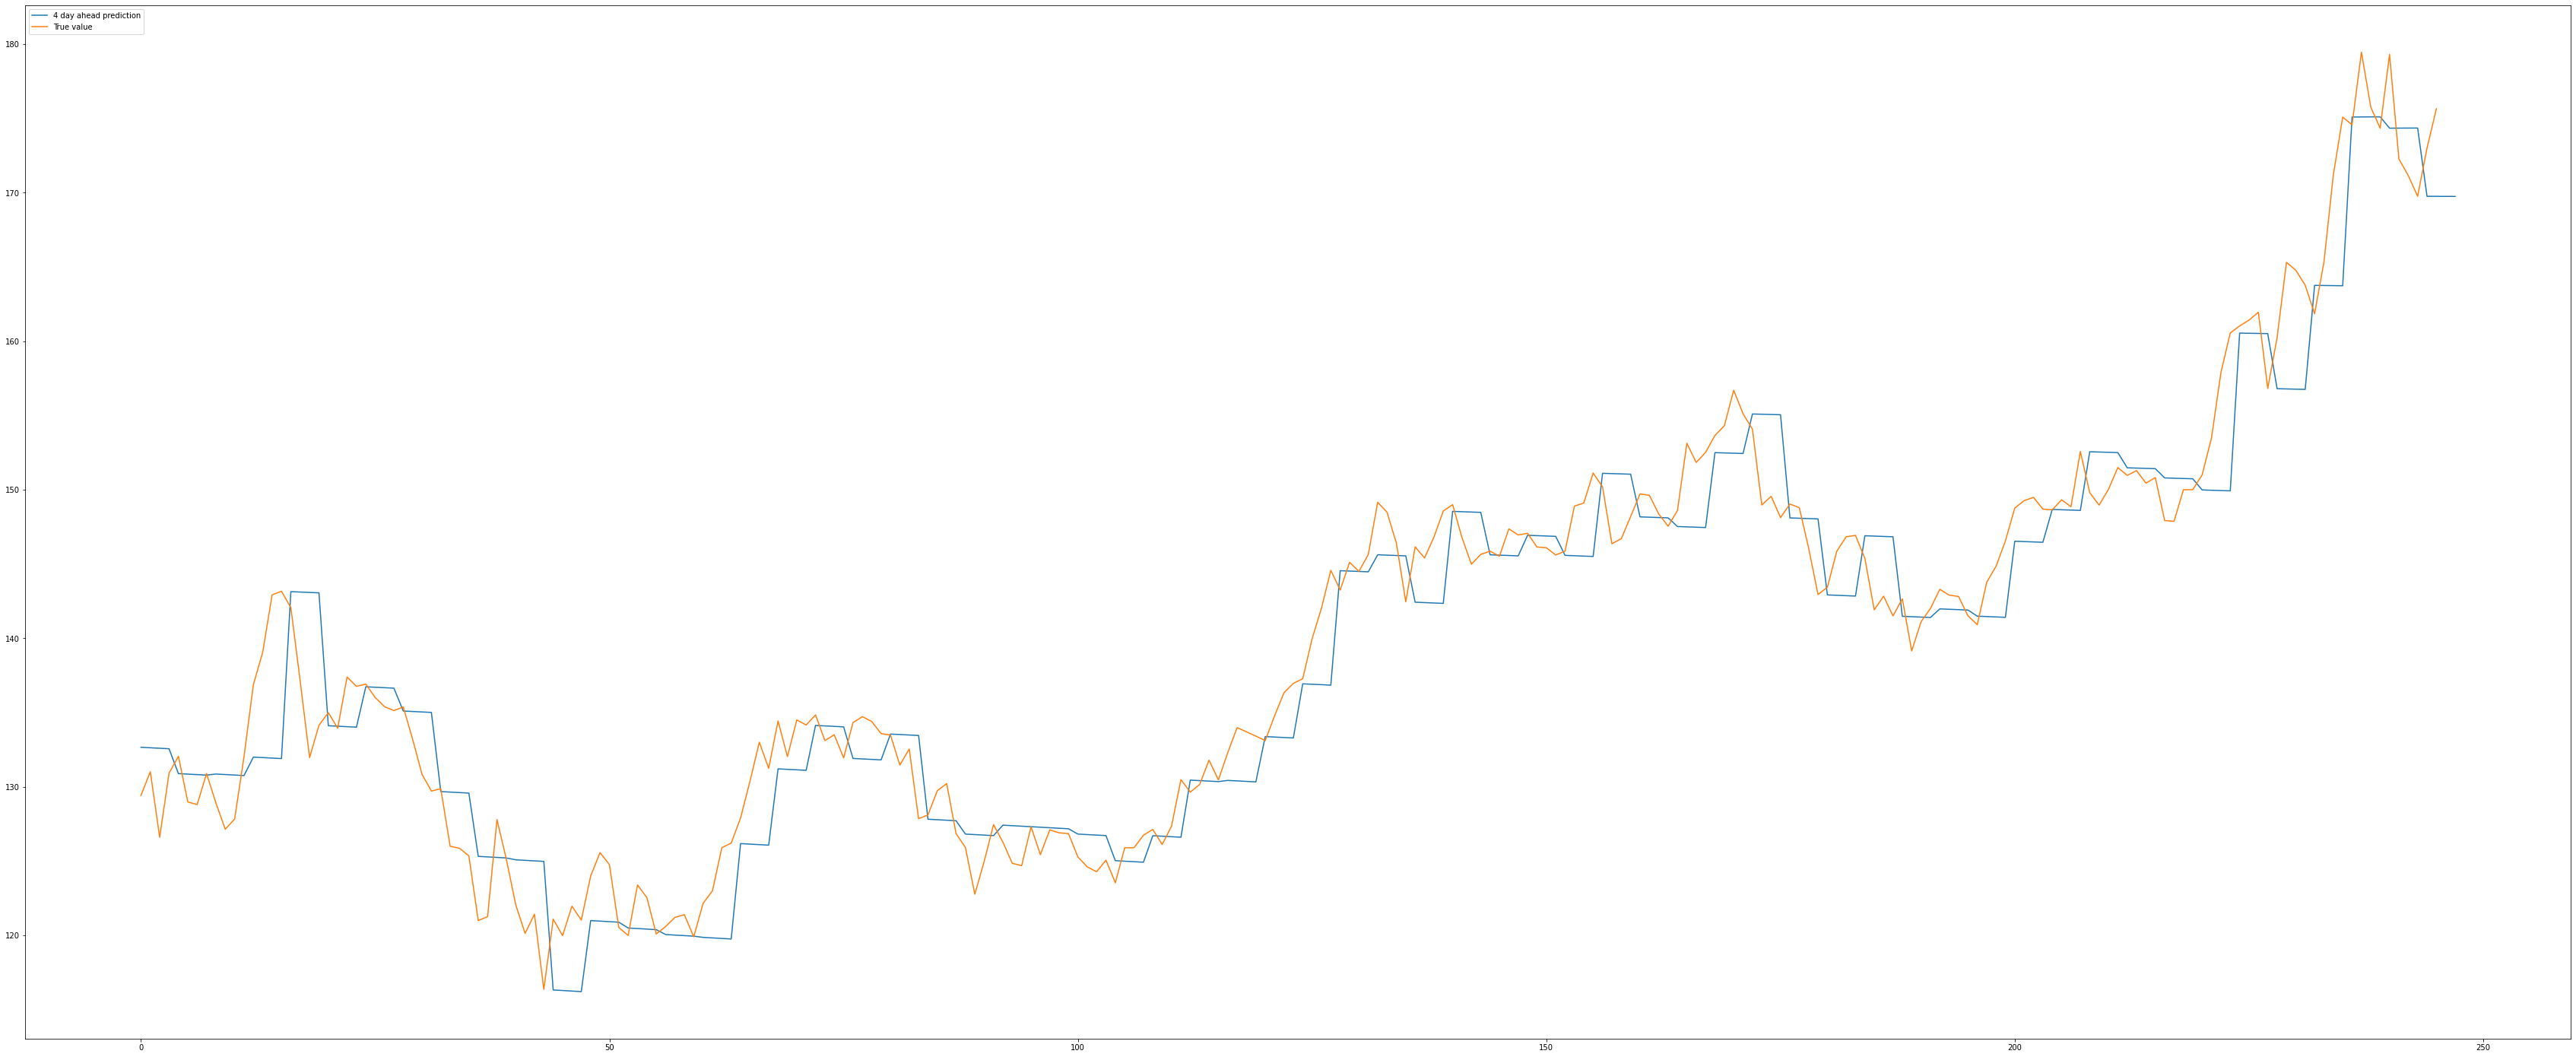

In [20]:
#here the model updates every n days which is not actually correct, the model should be updating every day we get new data
#here it is the case that we will be making to many predictions, we can see how our predictions change as we get knew data however. 
#we will see this in the slope difference trading strategy

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]

lag_n_pred = []
date = []
n = 4
test = test.reset_index(drop=True)


for i in range(0,len(test),n):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()

    #store predictions for the next two days
    predictions = model_fit.predict(start=len(train), end=len(train) +n-1)
    for index in range(n):
        lag_n_pred.append(predictions.iloc[index])
    
    #update the model with two days worth of data
    for j in range(n):
        if(i+j < len(test)):
            train = train.append({"Close": test.iloc[i+j]["Close"], "Date":test.iloc[i+j]["Date"]}, ignore_index=True)

plt.figure(figsize=(60,25))
plt.plot(lag_n_pred, label = str(n)+" day ahead prediction")
plt.plot(test["Close"], label = "True value")
plt.legend(loc="upper left")
plt.show()

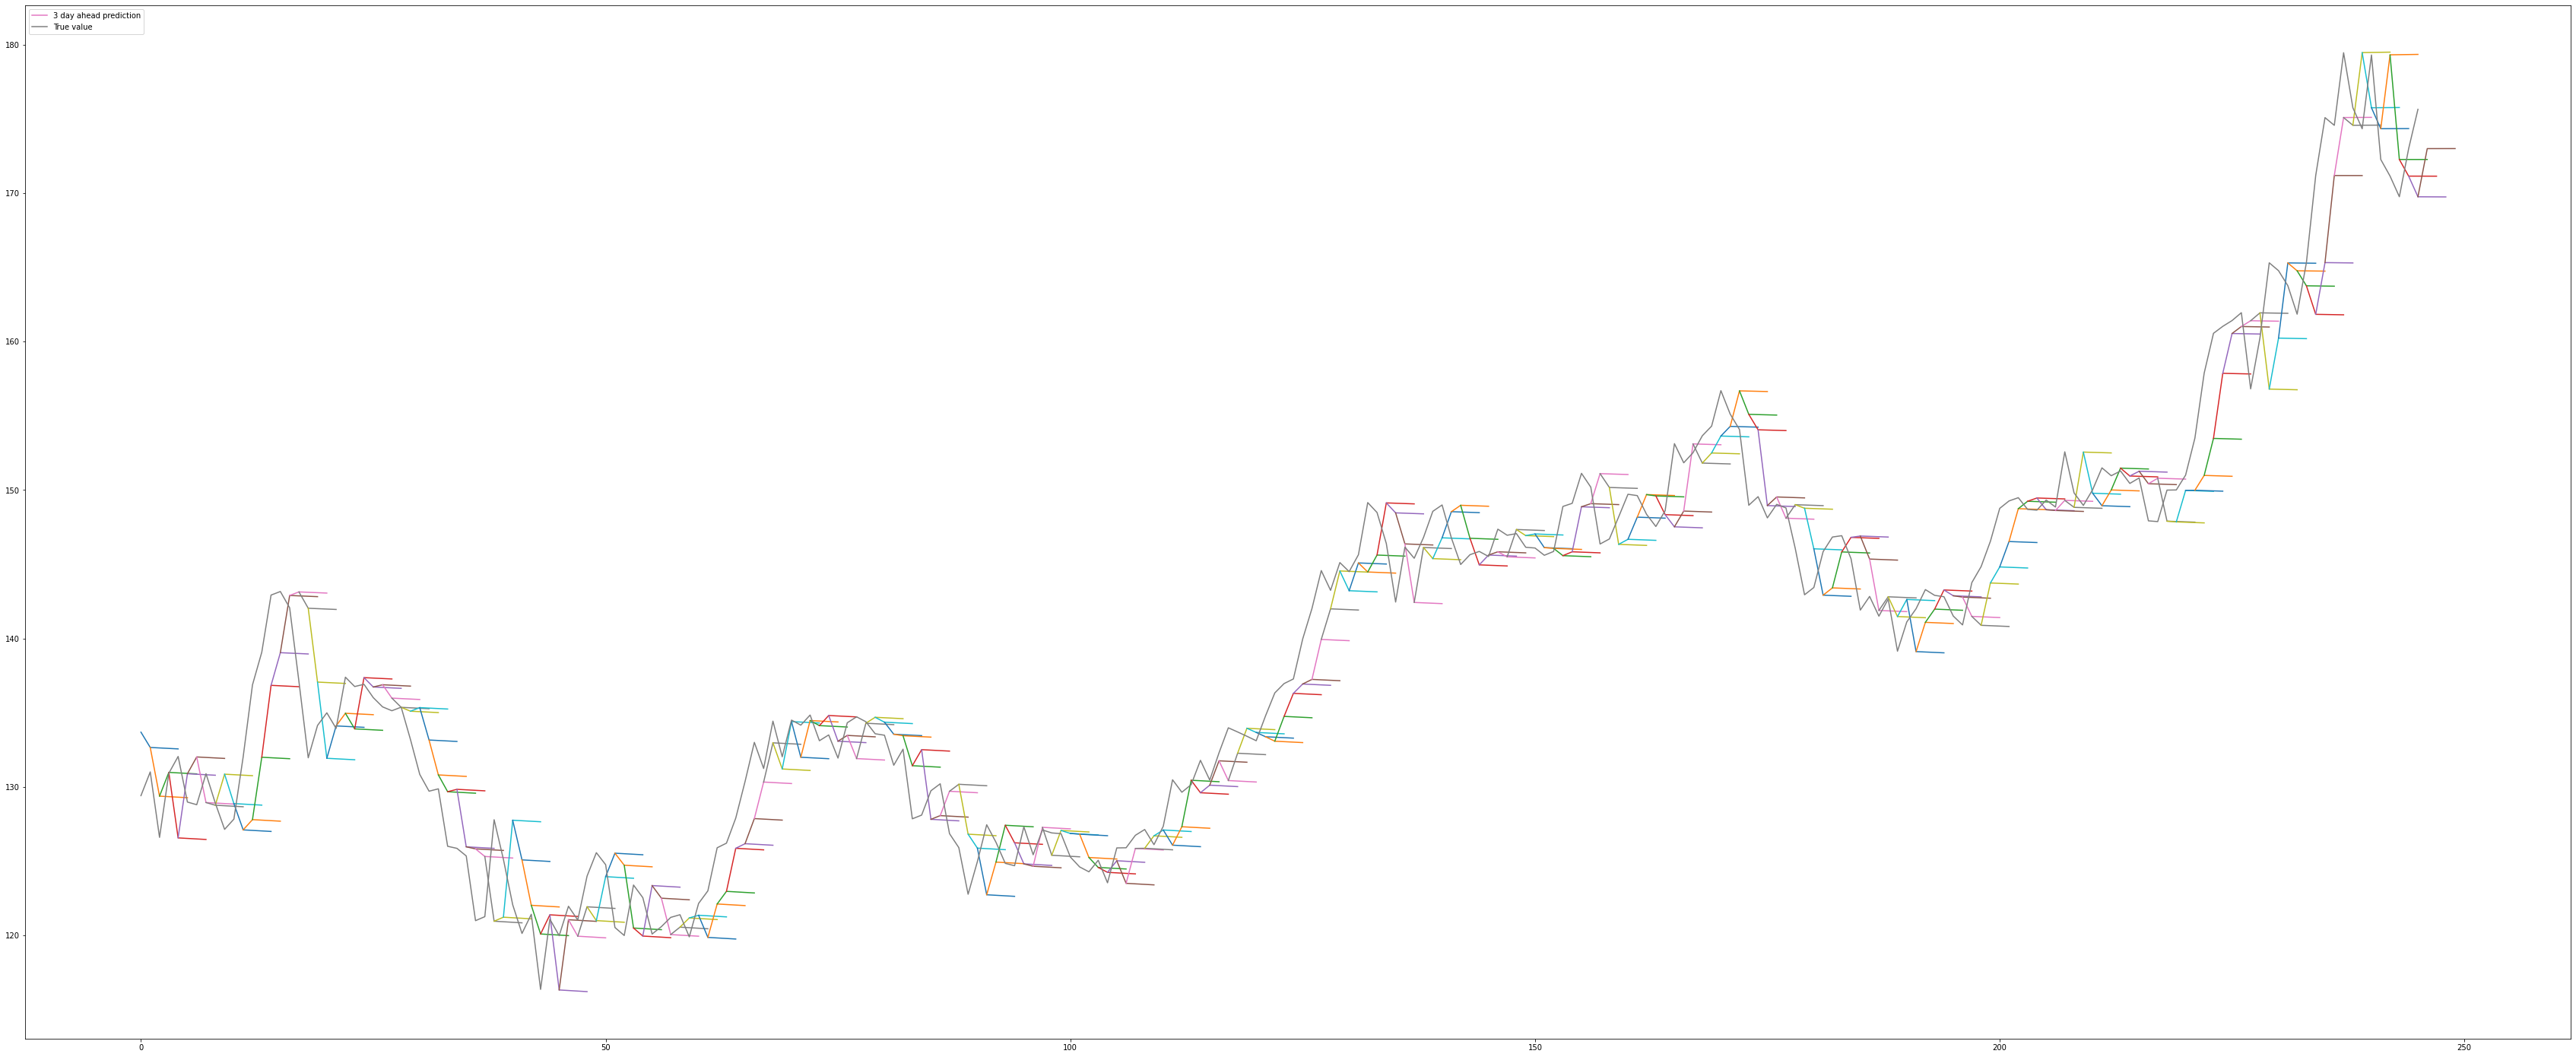

In [31]:
#we revise the above plot to show the difference of slopes trading strategy
#we see how our predictions change as we get new information to see what kind of trend we are in at the moment
#with using the difference of these slopes we can detece the strength of the trend
#one note is that here we do not use the actualy predicted values, we can even directly grab the value of the slope from the model
#here the model updates every n days which is not actually correct, the model should be updating every day we get new data
#here it is the case that we will be making to many predictions, we can see how our predictions change as we get knew data however. 
#we will see this in the slope difference trading strategy

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]

temp = []
lag_n_pred = []
date = []
n = 3
test = test.reset_index(drop=True)
plt.figure(figsize=(60,25))

for i in range(0,len(test)):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()

    #store predictions for the next two days
    predictions = model_fit.predict(start=len(train)-1, end=len(train)+n)

    for index in range(2+n):
        temp.append(predictions.iloc[index])
    
    plt.plot([x for x in range(i,i+2+n)], temp)
    temp = []
    
    #update the model with two days worth of data

    train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)


plt.plot(lag_n_pred, label = str(n)+" day ahead prediction")
plt.plot(test["Close"], label = "True value")
plt.legend(loc="upper left")
plt.show()


From this wacky graph we notice something interesting, we only have a real change from the current value to the next prediction, meaning that the difference of values between t and t +1 vary greatly, but after that t + 1 + n does not really change. Meaning there is a significant first difference, but the 1 +nth difference ~= 0

In [ ]:
#So for our trend line trading strat we can do as follows. Using a time window of the three slopes of t-2 to t-1 and t-1 to t and t to t+1 
#if slope(t,t+1) > slope(t-1,t) > slope(t-2,t-1) we are in a strong uptrend
#if slope(t,t+1) < slope(t-1,t) < slope(t-2,t-1) we are in a strong downtrend
#if other then we are in a period of consolidation

df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]




In [ ]:
#our next candidate is the forcasted moving average if the simple moving average with the forcast is about the 10 day SMA then we are in a weak uptrend
#if our simple moving average with forcast is about the 20 day SMA then we are in a strong uptrend.